<center>
    <h1>Rotten vs Fresh Fruit Detection</h1>
</center>

In [1]:
# Data Manipulation
import numpy as np
import pandas as pd
# Visualisation
import matplotlib.pyplot as plt
# Dataset exploring
import os

In [2]:
#pip install --upgrade tensorflow

## Libraries

In [1]:
# Dataset generation
from keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Transfert learning
from keras.applications import VGG16
# Optimizer
from keras.optimizers import Adam
# Keras layers
from keras.layers import Input, Dense, Dropout, Flatten, AveragePooling2D
# Keras model
from keras.models import Model
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shutil
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc

## Exploring data

In [4]:
classes = []
class_counter = 0

for dirname, _, filenames in os.walk('/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/train/'):
    if dirname.endswith('/'):
        continue
    else:
        classes.append({dirname.split('/')[-1]: 0})
    file_count = 0
    for filename in filenames:
        file_count += 1
    classes[class_counter][dirname.split('/')[-1]] = file_count
    class_counter += 1
    
print('{:<15} {:<15}'.format('Class', 'Number of instances'))
print()
for d in classes:
    [(k, v)] = d.items()
    print('{:<15} {:<15}'.format(k, v))

Class           Number of instances

rottenbanana    2224           
freshoranges    1466           
rottenoranges   1595           
freshbanana     1581           
rottenapples    2342           
freshapples     1693           


## Separating Apple Dataset

In [5]:
# Original dataset path
source_path = '/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/train/'

# New dataset path for apples only
target_path = './dataset_apples/'

# Classes to separate
apple_classes = ['freshapples', 'rottenapples']

# Create directories for training and validation
for subdir in ['train', 'val']:
    for apple_class in apple_classes:
        os.makedirs(os.path.join(target_path, subdir, apple_class), exist_ok=True)

# Function to copy files
def copy_files(source_class_path, target_class_path, train_split=0.8):
    # Get all files in the source class path
    files = os.listdir(source_class_path)
    total_files = len(files)
    train_count = int(total_files * train_split)
    
    # Shuffle and split files
    np.random.shuffle(files)
    train_files = files[:train_count]
    val_files = files[train_count:]
    
    # Copy train files
    for file in train_files:
        shutil.copy(os.path.join(source_class_path, file), target_class_path['train'])
    
    # Copy validation files
    for file in val_files:
        shutil.copy(os.path.join(source_class_path, file), target_class_path['val'])

# Copy files for each apple class
for apple_class in apple_classes:
    source_class_path = os.path.join(source_path, apple_class)
    target_class_paths = {
        'train': os.path.join(target_path, 'train', apple_class),
        'val': os.path.join(target_path, 'val', apple_class)
    }
    copy_files(source_class_path, target_class_paths)

print("Apple dataset separated successfully!")

Apple dataset separated successfully!


In [6]:
# Define paths
source_path = '/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/test/'
destination_path = './dataset_apples/test/'

# Classes to extract
target_classes = ['freshapples', 'rottenapples']

# Ensure the destination path exists
os.makedirs(destination_path, exist_ok=True)

for target_class in target_classes:
    # Source class path
    src_class_path = os.path.join(source_path, target_class)
    # Destination class path
    dest_class_path = os.path.join(destination_path, target_class)
    os.makedirs(dest_class_path, exist_ok=True)  # Create subdirectory if it doesn't exist

    # Copy all files from the source class folder to the destination folder
    for filename in os.listdir(src_class_path):
        src_file = os.path.join(src_class_path, filename)
        dest_file = os.path.join(dest_class_path, filename)
        if os.path.isfile(src_file):  # Ensure it's a file
            shutil.copy(src_file, dest_file)

print("Freshapples and Rottenapples have been copied to ./dataset_apples/test/")


Freshapples and Rottenapples have been copied to ./dataset_apples/test/


In [7]:
# Path to the new dataset directory
dataset_path = './dataset_apples/'

# Initialize a dictionary to store counts
class_counts = {'train': {}, 'val': {}, 'test': {}}

# Iterate through 'train' and 'val' directories
for subset in ['train', 'val', 'test']:
    subset_path = os.path.join(dataset_path, subset)
    for class_name in os.listdir(subset_path):
        class_path = os.path.join(subset_path, class_name)
        if os.path.isdir(class_path):
            # Count the number of files in the class directory
            class_counts[subset][class_name] = len(os.listdir(class_path))

# Print total number of instances for each class
print(f"{'Subset':<10} {'Class':<15} {'Instances':<10}")
print('-' * 35)
for subset, classes in class_counts.items():
    for class_name, count in classes.items():
        print(f"{subset:<10} {class_name:<15} {count:<10}")


Subset     Class           Instances 
-----------------------------------
train      rottenapples    1873      
train      freshapples     1354      
val        rottenapples    469       
val        freshapples     339       
test       rottenapples    601       
test       freshapples     395       


## Loading data

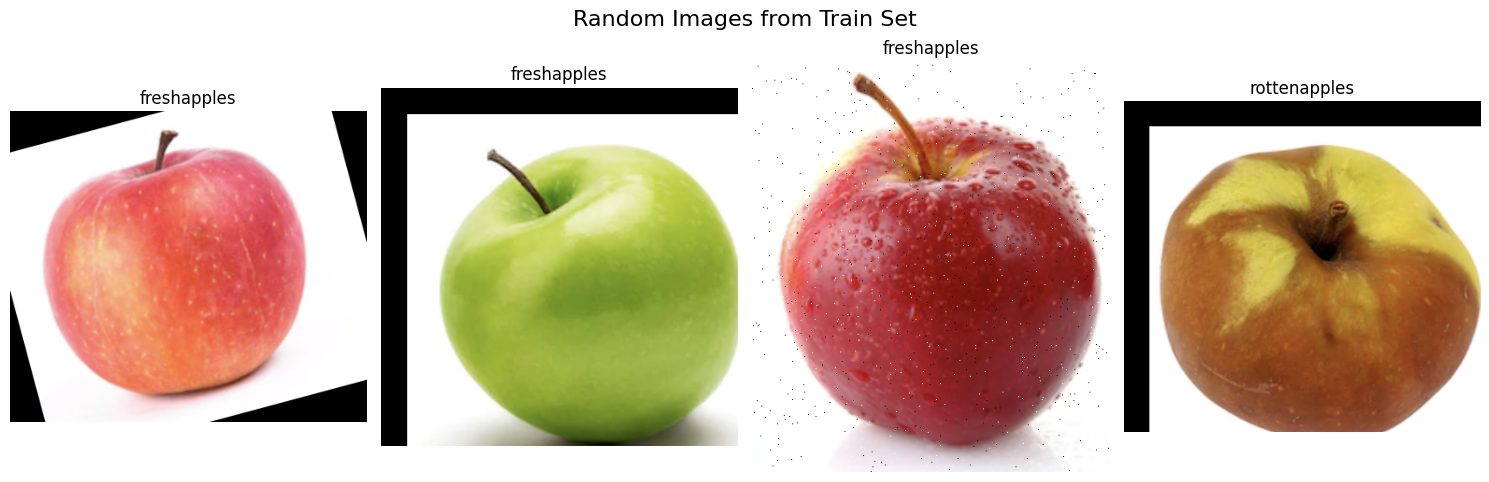

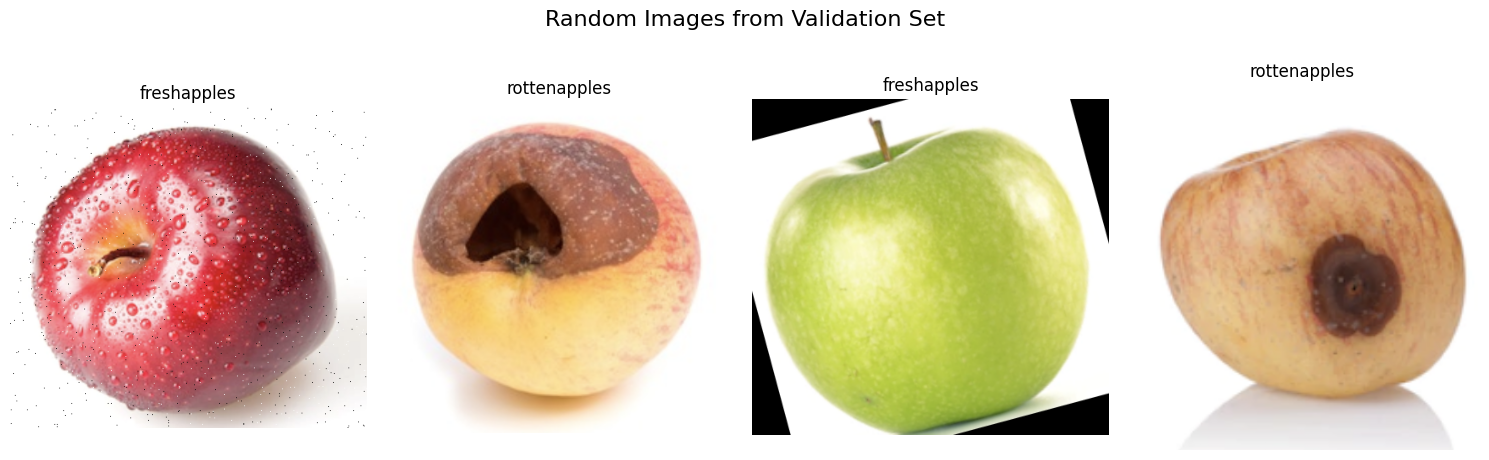

In [9]:
# Paths to train and validation datasets
TRAIN_PATH = './dataset_apples/train/'
VAL_PATH = './dataset_apples/val/'

# Function to display random images from a dataset
def display_random_images(dataset_path, title, num_images=4):
    classes = os.listdir(dataset_path)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    fig.suptitle(title, fontsize=16)
    
    for ax in axes:
        # Randomly choose a class
        chosen_class = random.choice(classes)
        class_path = os.path.join(dataset_path, chosen_class)
        
        # Randomly choose an image
        image_name = random.choice(os.listdir(class_path))
        image_path = os.path.join(class_path, image_name)
        
        # Load and display the image
        img = mpimg.imread(image_path)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(chosen_class)

    plt.tight_layout()
    plt.show()

# Display random images from the training set
display_random_images(TRAIN_PATH, "Random Images from Train Set")

# Display random images from the validation set
display_random_images(VAL_PATH, "Random Images from Validation Set")


In [10]:
datagen = ImageDataGenerator(
    rotation_range = 30, 
    zoom_range = .3, 
    horizontal_flip = True, 
    vertical_flip = True, 
    validation_split = .3
)

train_ds = datagen.flow_from_directory(
    directory = TRAIN_PATH,
    target_size = (256, 256),
    color_mode = 'rgb',
    class_mode = 'categorical',
    subset = 'training'
)

validation_ds = datagen.flow_from_directory(
    directory = TRAIN_PATH,
    target_size = (256, 256),
    color_mode = 'rgb',
    class_mode = 'categorical',
    subset = 'validation'
)

Found 2260 images belonging to 2 classes.
Found 967 images belonging to 2 classes.


In [11]:
# number of classes in directory
print(train_ds.class_indices)

{'freshapples': 0, 'rottenapples': 1}


## Creating model architecture
Note : We will be using VGG-16 for transfer learning

In [12]:
vgg16 = VGG16(include_top = False, weights = 'imagenet', input_shape = (256, 256, 3))
vgg16.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [13]:
X_input = Input(shape = (256, 256, 3))
X = vgg16(X_input)
X = AveragePooling2D(pool_size = (3, 3), strides = 2, padding = 'valid',name = 'AvgPool2D')(X)
X = Flatten(name = 'Flatten')(X)
X = Dense(200, activation = 'relu', name = 'Dense1')(X)
X = Dropout(.1)(X)
X = Dense(100, activation = 'relu', name = 'Dense2')(X)
X = Dropout(.1)(X)
X = Dense(2, activation = 'softmax', name = 'Dense3')(X)

model = Model(inputs = X_input, outputs = X, name = 'Apple_Classifer')

print(model.summary())

Model: "Apple_Classifer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 8, 8, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ AvgPool2D (AveragePooling2D)    │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense1 (Dense)                  │ (None, 200)            │       921,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense2 (Dense)                  │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense3 (Dense)                  │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,656,790 (59.73 MB)

 Trainable params: 942,102 (3.59 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [14]:
optimizer = Adam(learning_rate = 0.001)

model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

hist = model.fit(train_ds, validation_data = validation_ds, epochs = 8, batch_size = 32)

Epoch 1/8


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1734796271.684155     105 service.cc:145] XLA service 0x7b9fc800e650 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734796271.684218     105 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 2/71 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.4609 - loss: 7.5888  

I0000 00:00:1734796285.731411     105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


71/71 ━━━━━━━━━━━━━━━━━━━━ 76s 817ms/step - accuracy: 0.7664 - loss: 2.2306 - val_accuracy: 0.9535 - val_loss: 0.1477
Epoch 2/8
71/71 ━━━━━━━━━━━━━━━━━━━━ 47s 616ms/step - accuracy: 0.9528 - loss: 0.1728 - val_accuracy: 0.9772 - val_loss: 0.0704
Epoch 3/8
71/71 ━━━━━━━━━━━━━━━━━━━━ 46s 610ms/step - accuracy: 0.9725 - loss: 0.1041 - val_accuracy: 0.9804 - val_loss: 0.0415
Epoch 4/8
71/71 ━━━━━━━━━━━━━━━━━━━━ 47s 612ms/step - accuracy: 0.9670 - loss: 0.1114 - val_accuracy: 0.9835 - val_loss: 0.0506
Epoch 5/8
71/71 ━━━━━━━━━━━━━━━━━━━━ 47s 613ms/step - accuracy: 0.9740 - loss: 0.0742 - val_accuracy: 0.9855 - val_loss: 0.0380
Epoch 6/8
71/71 ━━━━━━━━━━━━━━━━━━━━ 47s 617ms/step - accuracy: 0.9773 - loss: 0.0740 - val_accuracy: 0.9907 - val_loss: 0.0270
Epoch 7/8
71/71 ━━━━━━━━━━━━━━━━━━━━ 46s 609ms/step - accuracy: 0.9868 - loss: 0.0470 - val_accuracy: 0.9804 - val_loss: 0.0542
Epoch 8/8
71/71 ━━━━━━━━━━━━━━━━━━━━ 47s 612ms/step - accuracy: 0.9869 - loss: 0.0420 - val_accuracy: 0.9845 - val

## Model evaluation using test data

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


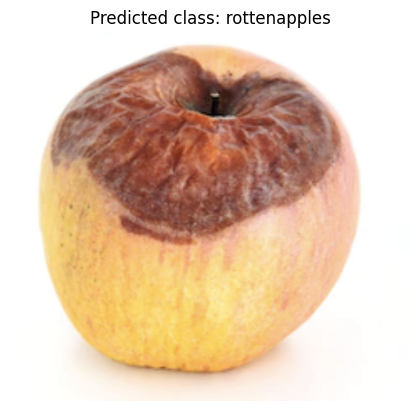

Predicted class: rottenapples
Predicted probabilities: [7.4208723e-35 1.0000000e+00]


In [15]:
new_image_path ='./dataset_apples/test/rottenapples/Screen Shot 2018-06-07 at 2.22.39 PM.png'
 
# Load the new image
img = image.load_img(new_image_path, target_size=(256, 256))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Make predictions
predictions = model.predict(img_array)

# Get the predicted class index
predicted_class_index = np.argmax(predictions)

# Get the class label
class_labels = list(train_ds.class_indices.keys())
predicted_class_label = class_labels[predicted_class_index]

# Display the image
img = mpimg.imread(new_image_path)
plt.imshow(img)
plt.axis('off')
plt.title(f'Predicted class: {predicted_class_label}')
plt.show()

# Print the results
print(f'Predicted class: {predicted_class_label}')
print(f'Predicted probabilities: {predictions[0]}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


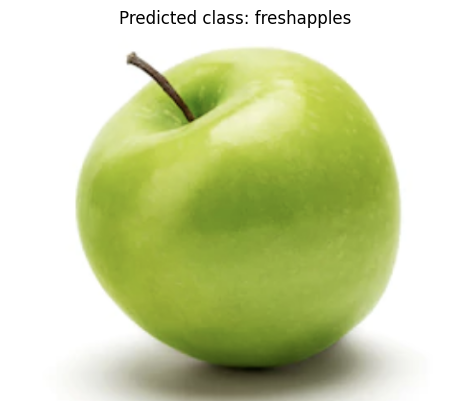

Predicted class: freshapples
Predicted probabilities: [1.0000000e+00 5.6680403e-09]


In [16]:
# Replace 'path_to_new_image.jpg' with the path to your new image
new_image_path ='./dataset_apples/test/freshapples/Screen Shot 2018-06-08 at 4.59.44 PM.png'

# Load the new image
img = image.load_img(new_image_path, target_size=(256, 256))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Make predictions
predictions = model.predict(img_array)

# Get the predicted class index
predicted_class_index = np.argmax(predictions)

# Get the class label
class_labels = list(train_ds.class_indices.keys())
predicted_class_label = class_labels[predicted_class_index]

# Display the image
img = mpimg.imread(new_image_path)
plt.imshow(img)
plt.axis('off')
plt.title(f'Predicted class: {predicted_class_label}')
plt.show()

# Print the results
print(f'Predicted class: {predicted_class_label}')
print(f'Predicted probabilities: {predictions[0]}')


In [17]:
# Load the test data for freshapples and rottenapples
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(
    './dataset_apples/val/',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Filter only freshapples and rottenapples class indices
class_labels = list(test_generator.class_indices.keys())
filtered_classes = ['freshapples', 'rottenapples']
filtered_indices = [test_generator.class_indices[cls] for cls in filtered_classes]

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Accuracy: {test_acc:.4f}")

# Make predictions on the test data
predictions = model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# Filter predictions and true labels to only include freshapples and rottenapples
y_true_filtered = [y for i, y in enumerate(y_true) if y in filtered_indices]
y_pred_filtered = [y for i, y in enumerate(y_pred) if y_true[i] in filtered_indices]

# Get the filtered class labels for reporting
filtered_class_labels = [class_labels[i] for i in filtered_indices]

# Print the classification report only for freshapples and rottenapples
print("Classification Report for Validation Data:")
print(classification_report(y_true_filtered, y_pred_filtered, target_names=filtered_class_labels))

# Confusion matrix for freshapples and rottenapples
cm = confusion_matrix(y_true_filtered, y_pred_filtered)
print("Confusion Matrix:")
print(cm)


Found 808 images belonging to 2 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 274ms/step - accuracy: 0.9664 - loss: 0.1628
Test Accuracy: 0.9715
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step
Classification Report for Validation Data:
              precision    recall  f1-score   support

 freshapples       0.98      0.95      0.97       339
rottenapples       0.96      0.99      0.98       469

    accuracy                           0.97       808
   macro avg       0.97      0.97      0.97       808
weighted avg       0.97      0.97      0.97       808

Confusion Matrix:
[[322  17]
 [  6 463]]


In [18]:
# Load the test data for freshapples and rottenapples
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(
    './dataset_apples/test/',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Filter only freshapples and rottenapples class indices
class_labels = list(test_generator.class_indices.keys())
filtered_classes = ['freshapples', 'rottenapples']
filtered_indices = [test_generator.class_indices[cls] for cls in filtered_classes]

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Accuracy: {test_acc:.4f}")

# Make predictions on the test data
predictions = model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# Filter predictions and true labels to only include freshapples and rottenapples
y_true_filtered = [y for i, y in enumerate(y_true) if y in filtered_indices]
y_pred_filtered = [y for i, y in enumerate(y_pred) if y_true[i] in filtered_indices]

# Get the filtered class labels for reporting
filtered_class_labels = [class_labels[i] for i in filtered_indices]

# Print the classification report only for freshapples and rottenapples
print("Classification Report for Test Data:")
print(classification_report(y_true_filtered, y_pred_filtered, target_names=filtered_class_labels))

# Confusion matrix for freshapples and rottenapples
cm = confusion_matrix(y_true_filtered, y_pred_filtered)
print("Confusion Matrix:")
print(cm)


Found 996 images belonging to 2 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 213ms/step - accuracy: 0.9641 - loss: 0.1459
Test Accuracy: 0.9719
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step
Classification Report for Test Data:
              precision    recall  f1-score   support

 freshapples       0.97      0.96      0.96       395
rottenapples       0.98      0.98      0.98       601

    accuracy                           0.97       996
   macro avg       0.97      0.97      0.97       996
weighted avg       0.97      0.97      0.97       996

Confusion Matrix:
[[380  15]
 [ 13 588]]


# Model Evaluation

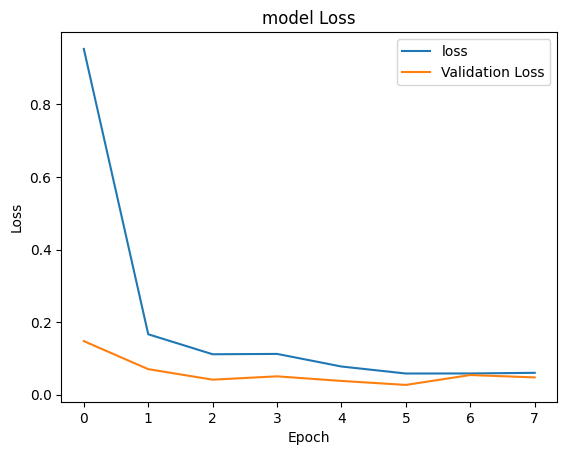

In [19]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["loss","Validation Loss"])
plt.show()

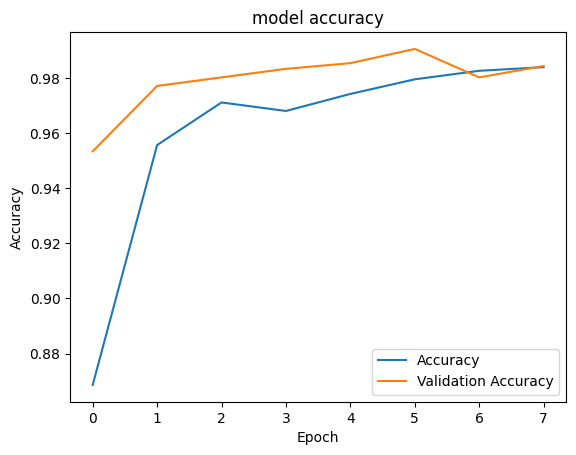

In [20]:
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.show()

# Visualizations of Findings

Found 996 images belonging to 2 classes.
 1/32 ━━━━━━━━━━━━━━━━━━━━ 6s 196ms/step

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step
Classification Report:
               precision    recall  f1-score   support

 freshapples       0.65      0.99      0.79       395
rottenapples       0.99      0.65      0.79       601

    accuracy                           0.79       996
   macro avg       0.82      0.82      0.79       996
weighted avg       0.86      0.79      0.79       996



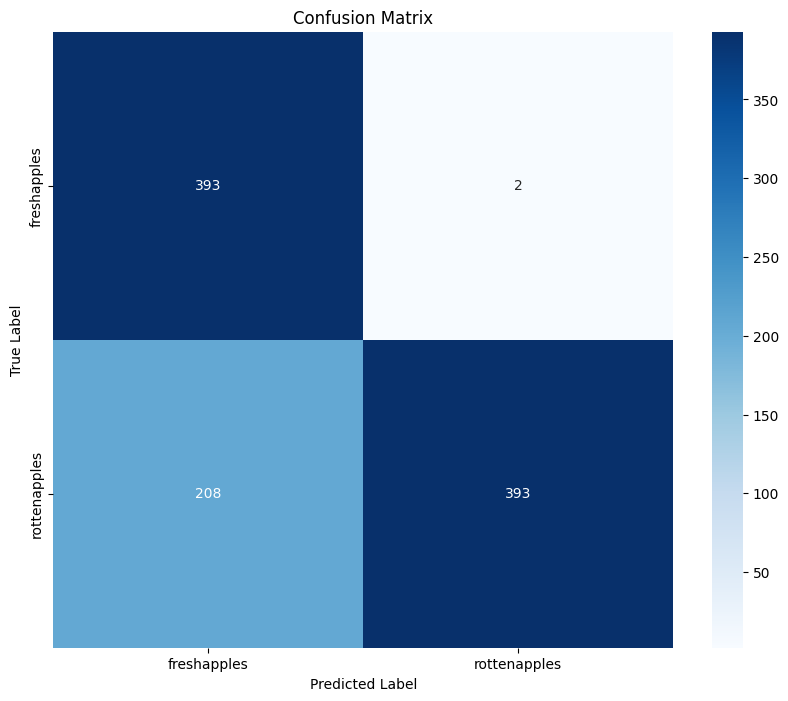

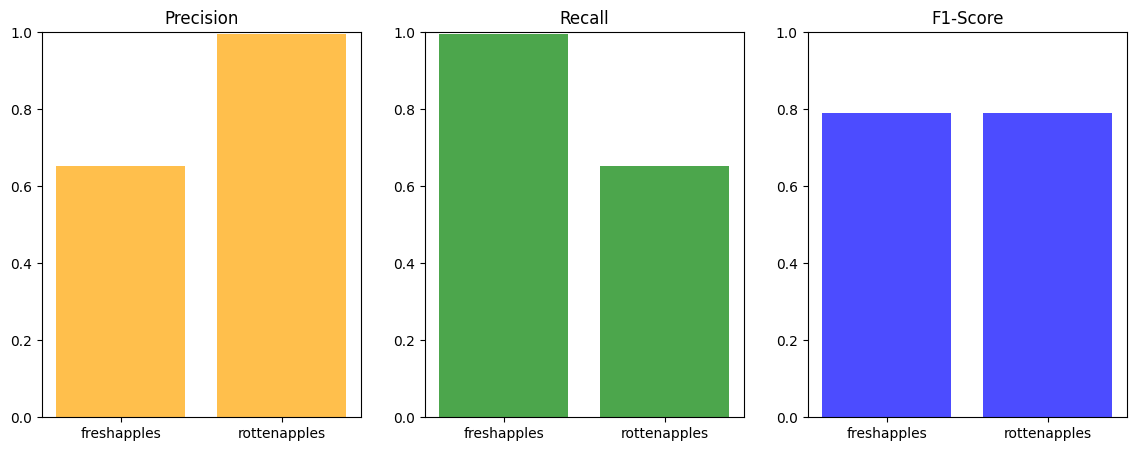

In [21]:
TEST_PATH = './dataset_apples/test/'

# Data preparation for test set
test_datagen = ImageDataGenerator(
    rescale=1./255
)

# Generate predictions for the entire test set
test_generator = test_datagen.flow_from_directory(
    directory=TEST_PATH,
    target_size=(256, 256),
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False
)

# Get true labels
true_labels = test_generator.classes

# Make predictions
predictions = model.predict(test_generator)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Display classification report
class_names = list(test_generator.class_indices.keys())
classification_rep = classification_report(true_labels, predicted_labels, target_names=class_names)
print("Classification Report:\n", classification_rep)

# Visualize confusion matrix using seaborn
plt.figure(figsize=(10, 8))

# Heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Visualize precision, recall, and F1-score
precision = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)
recall = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
f1_score = 2 * (precision * recall) / (precision + recall)

# Bar plots
plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
plt.bar(class_names, precision, color='orange', alpha=0.7)
plt.title('Precision')
plt.ylim(0, 1)

plt.subplot(1, 3, 2)
plt.bar(class_names, recall, color='green', alpha=0.7)
plt.title('Recall')
plt.ylim(0, 1)

plt.subplot(1, 3, 3)
plt.bar(class_names, f1_score, color='blue', alpha=0.7)
plt.title('F1-Score')
plt.ylim(0, 1)

plt.show()


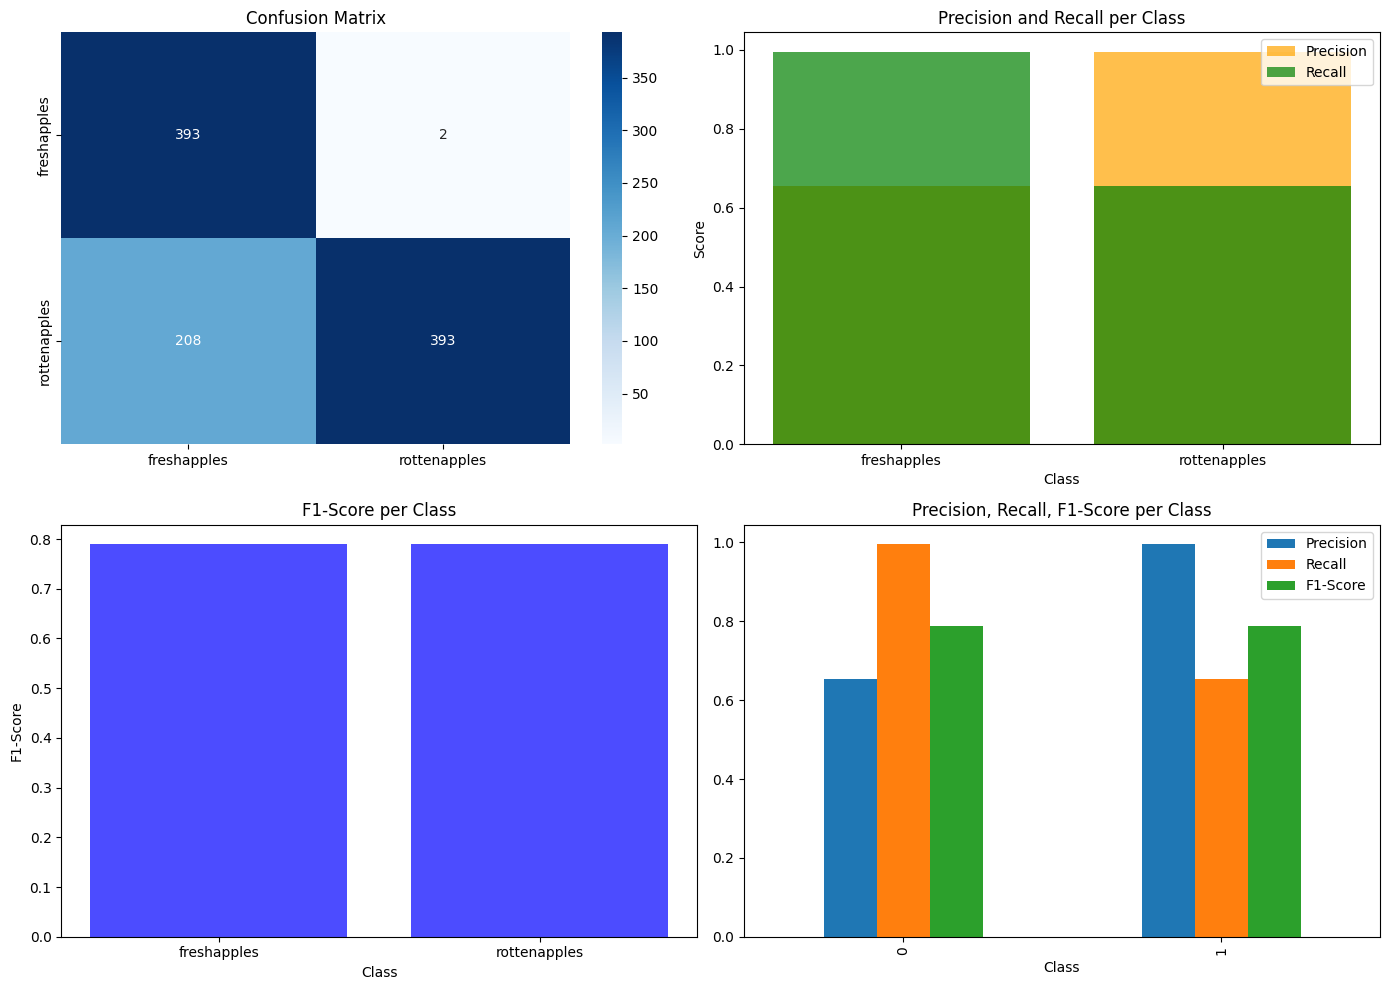

In [22]:
# Convert class labels to integers
label_encoder = LabelEncoder()
true_labels_encoded = label_encoder.fit_transform(true_labels)
predicted_labels_encoded = label_encoder.transform(predicted_labels)

# Get precision, recall, and F1-Score for each class
precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels_encoded, predicted_labels_encoded, average=None)

# Set up the matplotlib figure
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Confusion Matrix Heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=axes[0, 0])
axes[0, 0].set_title('Confusion Matrix')

# Precision-Recall per Class
axes[0, 1].bar(class_names, precision, color='orange', alpha=0.7, label='Precision')
axes[0, 1].bar(class_names, recall, color='green', alpha=0.7, label='Recall')
axes[0, 1].set_xlabel('Class')
axes[0, 1].set_ylabel('Score')
axes[0, 1].set_title('Precision and Recall per Class')
axes[0, 1].legend()

# F1-Score per Class
axes[1, 0].bar(class_names, f1_score, color='blue', alpha=0.7)
axes[1, 0].set_xlabel('Class')
axes[1, 0].set_ylabel('F1-Score')
axes[1, 0].set_title('F1-Score per Class')

# Bar plot for Precision, Recall, F1-Score
metrics_df = pd.DataFrame({'Precision': precision, 'Recall': recall, 'F1-Score': f1_score})
metrics_df.index.name = 'Class'

metrics_df.plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_title('Precision, Recall, F1-Score per Class')

plt.tight_layout()
plt.show()


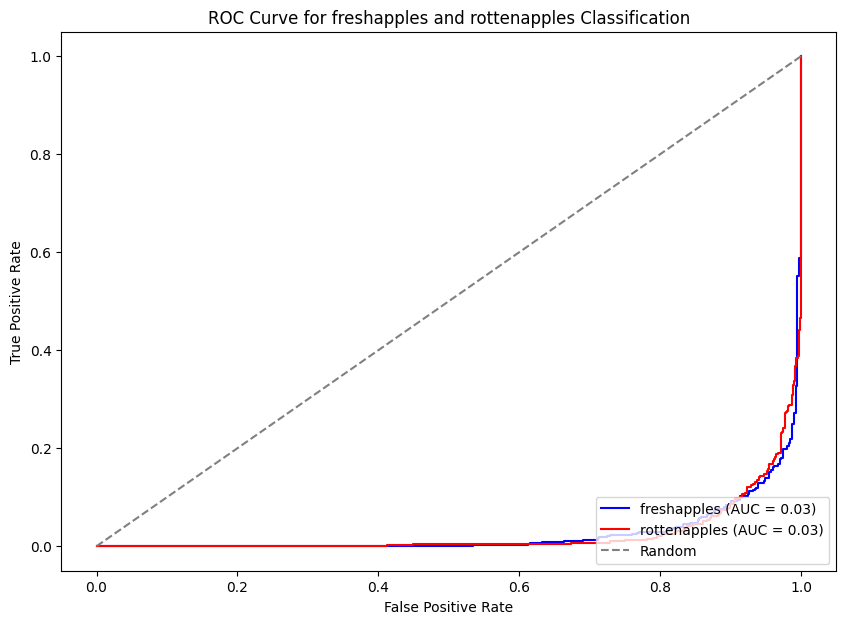

In [30]:
# predictions: shape (n_samples, 2) - probabilities for each class
# true_labels_encoded: shape (n_samples,) - integer-encoded true labels (0 or 1)

# Compute ROC curve and AUC for the positive class (class 1)
fpr = {}
tpr = {}
roc_auc = {}

# For "freshapples" class (class 0)
fpr[0], tpr[0], _ = roc_curve(true_labels_encoded, predictions[:, 0])
roc_auc[0] = auc(fpr[0], tpr[0])

# For "rottenapples" class (class 1)
fpr[1], tpr[1], _ = roc_curve(1 - true_labels_encoded, predictions[:, 1])
roc_auc[1] = auc(fpr[1], tpr[1])

# Plot the ROC curves
plt.figure(figsize=(10, 7))
plt.plot(fpr[0], tpr[0], label=f'freshapples (AUC = {roc_auc[0]:.2f})', color='blue')
plt.plot(fpr[1], tpr[1], label=f'rottenapples (AUC = {roc_auc[1]:.2f})', color='red')

# Plot a diagonal line representing random performance
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for freshapples and rottenapples Classification')
plt.legend(loc='lower right')

# Show the plot
plt.show()
